#Question 4 on IRIS data

In [45]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds,eigs
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [46]:
def get_lower_dim(data,basis):#expects features in the columns and samples in the row of data and for basis matrix each column is a basis vector
  return np.dot(data,basis)

In [47]:
class Denoiser:

  def __init__(self,data,final_dim) :
    self.data=data
    self.mean=data.mean(axis=0)
    self.std=data.std(axis=0)
    self.dim=final_dim

  #SVD Based
  def get_svs(self) :
    zero_mean=(self.data-self.mean)/self.std
    u,s,v=svds(zero_mean,k=self.dim,which='LM')
    v=v.T
    v[:, [0, 1]] = v[:, [1, 0]]
    return v

  #Covariance_matrix Based
  def get_eigvs(self):
    zero_mean=(self.data-self.mean)/self.std
    l=self.data.shape[0]
    cov=(1/l)*(zero_mean.dot(zero_mean.T))
    vals,eig=eigs(cov,k=self.dim)
    return eig

  def get_dim(self,D,svs=False,eigvs=False):
    Dt=(D-self.mean)/self.std
    if svs==True :
      v=self.get_svs()
      final=Dt.dot(v)
      return final,v
    if eigvs==True :
      v=self.get_eigvs()
      final=Dt.dot(v)
      return final

  def Reconstruct(self,D,svs=False,eigvs=False) :
    if svs==True:
      Final,v=self.get_dim(D,svs)
    if eigvs==True:
      Final,v=self.get_dim(D,eigvs)
    Recons=Final.dot(v.T)*self.std+self.mean
    return Recons

# Load the Data

In [48]:
Iris_data=pd.read_csv('/content/drive/MyDrive/ID5055 assignments/PCA assignment 1/Iris.csv')

# Exploring the Data

In [49]:
Iris_data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [50]:
columns=Iris_data.columns#exclude the last column as it is the class label
Train=Iris_data[columns[1:-1]]

In [51]:
Train

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


# Performing standardization

In [52]:
S=StandardScaler()
Normalized=S.fit_transform(Train)#Normalizing the data
PCA_IRIS=Denoiser(Normalized,final_dim=2).get_svs()# get the singular vectors

# Singular basis vectors
The columns are the vectors. From left to right they are according to the decreasing order of singular values. So First singular vector is more important in distingushing the classes.

In [53]:
PCA_IRIS# viewing the singular vectors on to which the data will be projected.

array([[ 0.52237162, -0.37231836],
       [-0.26335492, -0.92555649],
       [ 0.58125401, -0.02109478],
       [ 0.56561105, -0.06541577]])

In [54]:
Lower_dim_data= get_lower_dim(data=Normalized,basis=PCA_IRIS)

In [55]:
labels=Iris_data[columns[-1]]

In [56]:
np.unique(labels)

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [57]:
l=LabelEncoder()
enc_labels=l.fit_transform(labels)
color=['red','green','blue']
mapping_df = Iris_data[['Species']].copy() #Create an extra dataframe which will be used to address only the encoded values
mapping_df['labels_encoded'] = l.fit_transform(Iris_data['Species']) #Using values is faster than using list
#mapping_df.drop_duplicates().drop('Species', axis=1)
mapping_df.drop_duplicates('Species')

,Species,labels_encoded
0,Iris-setosa,0
50,Iris-versicolor,1
100,Iris-virginica,2


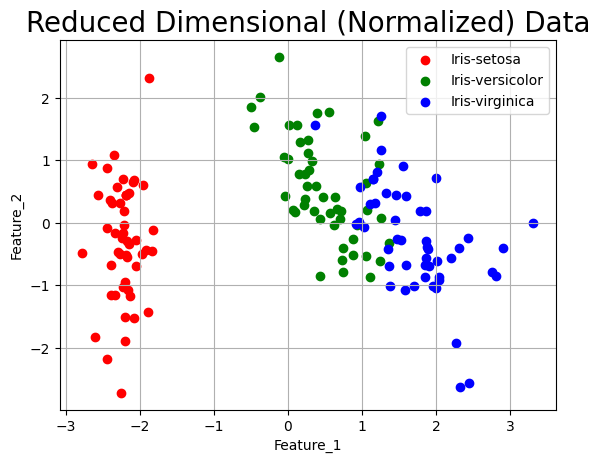

In [58]:
import matplotlib
plt.scatter(Lower_dim_data[:,0][enc_labels==0],Lower_dim_data[:,1][enc_labels==0],c=color[0],label='Iris-setosa')
plt.scatter(Lower_dim_data[:,0][enc_labels==1],Lower_dim_data[:,1][enc_labels==1],c=color[1],label='Iris-versicolor')
plt.scatter(Lower_dim_data[:,0][enc_labels==2],Lower_dim_data[:,1][enc_labels==2],c=color[2],label='Iris-virginica')
#plt.scatter(Lower_dim_data[:,0],Lower_dim_data[:,1],c=enc_labels,cmap=matplotlib.colors.ListedColormap(color))
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.title("Reduced Dimensional (Normalized) Data",fontsize=20)
plt.grid()
plt.legend()
plt.savefig('LowerDim.png')
plt.show()

# To get the nost important feature we check the absolute largest coffiecient of the first principal component and it is 0.5812. This corresponds to the fearture **PetalLengthcm**

In [59]:
idx=np.argmax(PCA_IRIS[:,0])
most_imp_feature=Train.columns[idx]
print(most_imp_feature)

PetalLengthCm


#End of Question 4